In [67]:
import numpy as np
import pandas as pd
from statsmodels.api import OLS
import sklearn.model_selection as skm
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
import sklearn.linear_model as skl
from matplotlib.pyplot import subplots

########################
########################

from sklearn.pipeline import Pipeline
from sklearn.decomposition import  PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)

Subset Selection methods

In [68]:
#1 Forward Selection

# Here wqe implement mehtods that reduce the number of parameters iun a model by restricting the model to a subset of the input variables

Hitters = load_data('Hitters')
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [69]:
Hitters.isna().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [70]:
Hitters.dropna(inplace=True)

In [71]:
Hitters.shape

(263, 20)

In [72]:
# We first choose the best model using forward selection based on Cp. This score is not built in as a metric to sklean. We therefore define a funciton to compute it ourselves, and use it as a scorer. By default, skleaen tries to maximize a score, hence our scoring funciton computes the negative Cp statistic

def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2)/n

In [73]:
# We nedd to estimate the residual variance omega**2, which is the first argument in our scoreing funciton above. We wil fit the biggest model, using all the variables, and estimate omega*82 based on its MSE

design =  MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

In [74]:
# The function sklearn_selected() expects a scorer with just three arguments -  the last three in the definition of nCp() above. We use the funciton partial() to freeze the first argument with our estimate of sigma**2


neg_Cp = partial(nCp, sigma2)

# Now we can use neg_Cp() as a scorer for model selection.

In [75]:
# Along with a score we need to specify the search strategy. This is done through the object Stepwise() in the ISLP.models package. The method Stepwise.first_peak() runs forward stepwiwse until any further additions to the model do not result in an improvement in the evaluation score

strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

In [76]:
# We now fit a linear regression model with salary as outcome using forward selection. To do so, we use the funciton sklearn_selected() from the ISLP.models package. This takes a model from statsmodels along with a search strategy and selects a model with its fit method. Wihtout specifying a scoreing argumet, the score defaults to MSE, and so all 19 variables will be selected


hitters_MSE = sklearn_selected(OLS, strategy=strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [77]:
# Now using the neg_Cp results in a smaller model, as expected, with just 10 variables selected

hitters_Cp = sklearn_selected(OLS, strategy=strategy, scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

In [78]:
# As an alternative to using Cp, we might try cross-validation to select a model in forward selection . For this, we need a method that stores the full path of models found in forward selection , and allows predictions for each of these


strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')

full_path =   sklearn_selection_path(OLS, strategy)

In [79]:
full_path.fit(Hitters, Y)

In [80]:
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

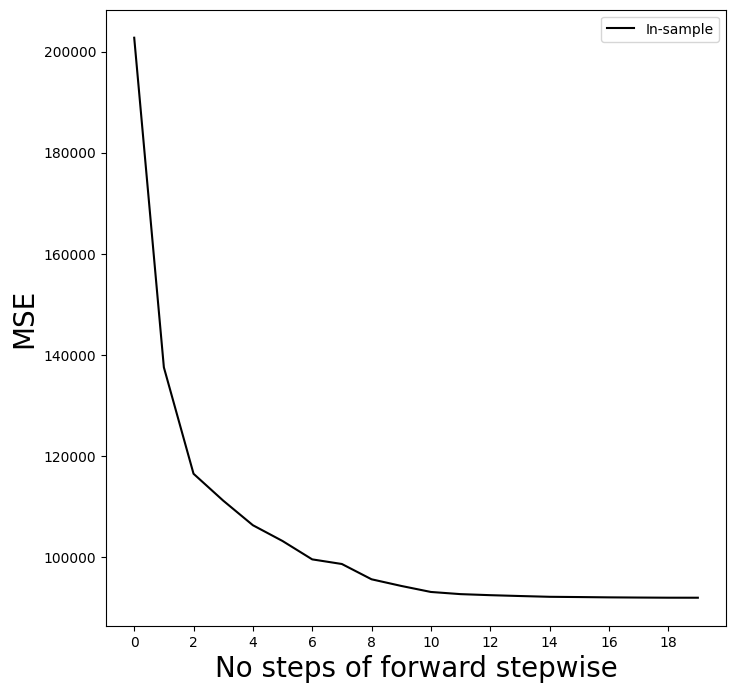

In [81]:
# This gives us an array of fitted values 20 steps in all, including the fitted mean for the null model which we can use to evaluate in samples MSE. As expected the in-sample MSE improves each step we take, indicating we must use either the validation or cross_validation approach to select the number of steps. We fix the y-axis to range from 50000 to 250000 to compare to the cross-validation and validation set MSE below, as well as other methods such as ridge regression , lasso andn principal components regression


mse_fig, ax= subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k',
        label='In-sample')
ax.set_ylabel('MSE', fontsize=20)
ax.set_xlabel("No steps of forward stepwise", fontsize=20)

ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()

In [82]:
# We will now use cross-validation to estimate test error along the model path


K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,
                                Hitters,
                                Y,
                                cv=kfold)
Yhat_cv.shape

(263, 20)

In [83]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx, None])**2
    cv_mse.append(errors.mean(0))
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

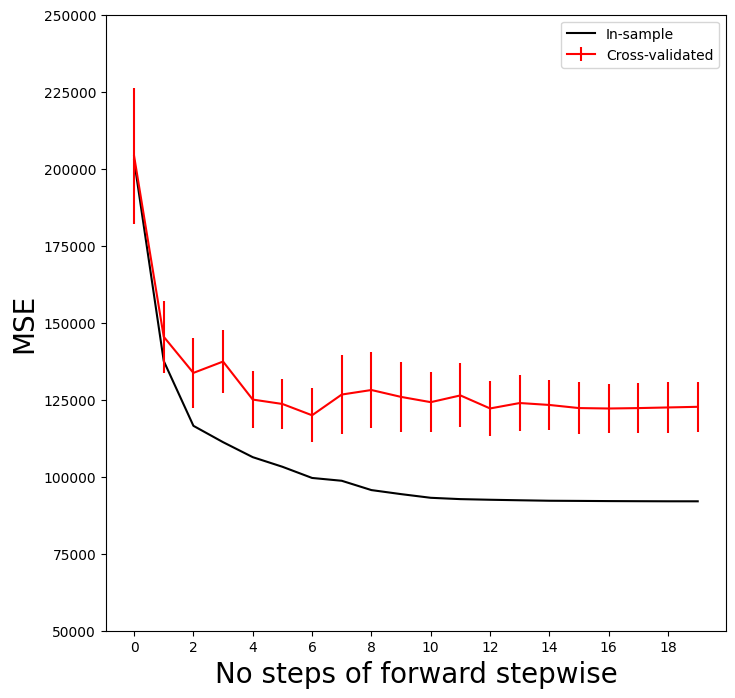

In [84]:
# We now add the cross-validation error estimates to out MSE plot

ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1)/np.sqrt(K),
            label='Cross-validated',
            c='r')
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

In [85]:
# Now using validation set aproach

validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.2,
                              random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx],
                  Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx, None])**2
    validation_mse = errors.mean(0)

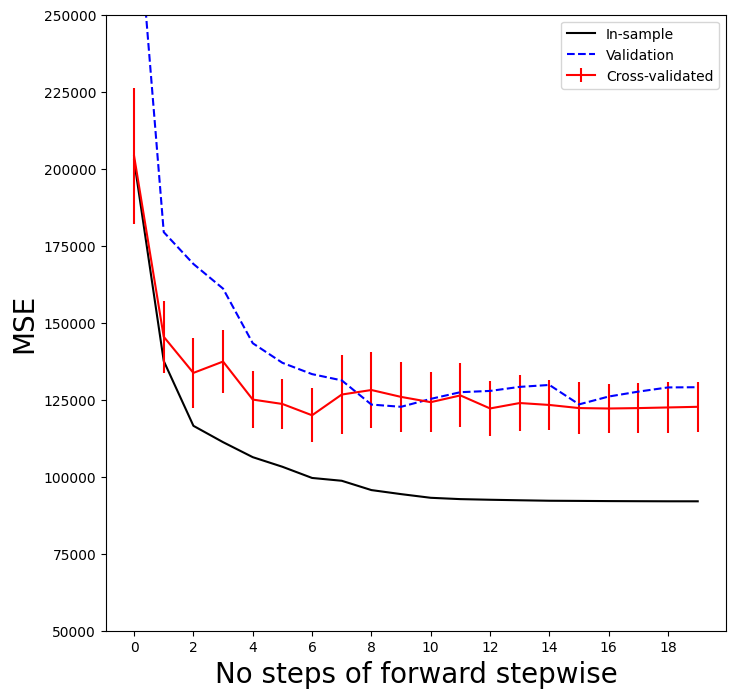

In [86]:
# As for the in-sample MSE case, the validation set approach does not provide standard errors

ax.plot(np.arange(n_steps),
        validation_mse,
        'b--', # color blue, broken line
        label='Validation')

ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

Ridge Regression and the Lasso

In [87]:
np.isnan(X).sum()

intercept       0
AtBat           0
Hits            0
HmRun           0
Runs            0
RBI             0
Walks           0
Years           0
CAtBat          0
CHits           0
CHmRun          0
CRuns           0
CRBI            0
CWalks          0
League[N]       0
Division[W]     0
PutOuts         0
Assists         0
Errors          0
NewLeague[N]    0
dtype: int64

In [88]:
X

,intercept,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
1,1.0,315,81,7,24,38,39,14,3449,835,69,321,414,375,1.0,1.0,632,43,10,1.0
2,1.0,479,130,18,66,72,76,3,1624,457,63,224,266,263,0.0,1.0,880,82,14,0.0
3,1.0,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1.0,0.0,200,11,3,1.0
4,1.0,321,87,10,39,42,30,2,396,101,12,48,46,33,1.0,0.0,805,40,4,1.0
5,1.0,594,169,4,74,51,35,11,4408,1133,19,501,336,194,0.0,1.0,282,421,25,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,1.0,497,127,7,65,48,37,5,2703,806,32,379,311,138,1.0,0.0,325,9,3,1.0
318,1.0,492,136,5,76,50,94,12,5511,1511,39,897,451,875,0.0,0.0,313,381,20,0.0
319,1.0,475,126,3,61,43,52,6,1700,433,7,217,93,146,0.0,1.0,37,113,7,0.0
320,1.0,573,144,9,85,60,78,8,3198,857,97,470,420,332,0.0,0.0,1314,131,12,0.0


In [90]:
X

,intercept,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
1,1.0,315,81,7,24,38,39,14,3449,835,69,321,414,375,1.0,1.0,632,43,10,1.0
2,1.0,479,130,18,66,72,76,3,1624,457,63,224,266,263,0.0,1.0,880,82,14,0.0
3,1.0,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1.0,0.0,200,11,3,1.0
4,1.0,321,87,10,39,42,30,2,396,101,12,48,46,33,1.0,0.0,805,40,4,1.0
5,1.0,594,169,4,74,51,35,11,4408,1133,19,501,336,194,0.0,1.0,282,421,25,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,1.0,497,127,7,65,48,37,5,2703,806,32,379,311,138,1.0,0.0,325,9,3,1.0
318,1.0,492,136,5,76,50,94,12,5511,1511,39,897,451,875,0.0,0.0,313,381,20,0.0
319,1.0,475,126,3,61,43,52,6,1700,433,7,217,93,146,0.0,1.0,37,113,7,0.0
320,1.0,573,144,9,85,60,78,8,3198,857,97,470,420,332,0.0,0.0,1314,131,12,0.0


In [94]:
# We will use the sklearn.linear_model package to fit ridge and lasso regularized linear models on the Hitters data. We start with the model matrix X(wihout an intercept) that we computed in the previous section on best subset regression.

# Ridge Regression

Xs = X-X.mean()
Xs.drop('intercept', axis=1, inplace=True)
X_scale  = X.std(0)
Xs = Xs/X_scale
lambdas = 10**np.linspace(8,-2,100)/Y.std()
soln_array = skl.ElasticNet.path(Xs, Y, l1_ratio=0.,alphas=lambdas)[1]
soln_array.shape

/home/susearc/Macos/py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/home/susearc/Macos/py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64428166.76205693, tolerance: 12885.7065737425
  model = cd_fast.enet_coordinate_descent_gram(
/home/susearc/Macos/py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/home/susearc/Macos/py3.11/lib/python3.11/site-packages/sklearn/linear_model

(19, 100)

In [ ]:
# Here we extract the array of coefficients corresponding to the solutions along the regularization path. By default the skl.ElasticNet.path method fits a path along an automatically selected range of lambda values, except for the case when l1_ratio=0

soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index = -np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

In [97]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True,with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge',ridge)])
pipe.fit(X,Y)

/home/susearc/Macos/py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+07, tolerance: 5.332e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.24374766133488554, l1_ratio=0))])

Estimating Test Error of Ridge Regression

In [98]:
np.linalg.norm(ridge.coef_)

160.42371017725904

In [100]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.5,
                              random_state=0)

ridge_alpha = 0.01

results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)

-results['test_score']

/home/susearc/Macos/py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.569e+06, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([134063.85257629])

In [101]:
ridge.alpha = 1e10
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)

/home/susearc/Macos/py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [102]:
-results['test_score']

array([231788.32155285])

In [103]:
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=validation,
                        scoring='neg_mean_squared_error')

grid.fit(X,Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

/home/susearc/Macos/py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/susearc/Macos/py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers im

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005899006046740856, l1_ratio=0))])

In [104]:
# Alternatively, we can use 5-fold cross-validation

grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')

grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

/home/susearc/Macos/py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/susearc/Macos/py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers im

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))])

Text(0, 0.5, 'Cross-validated MSE')

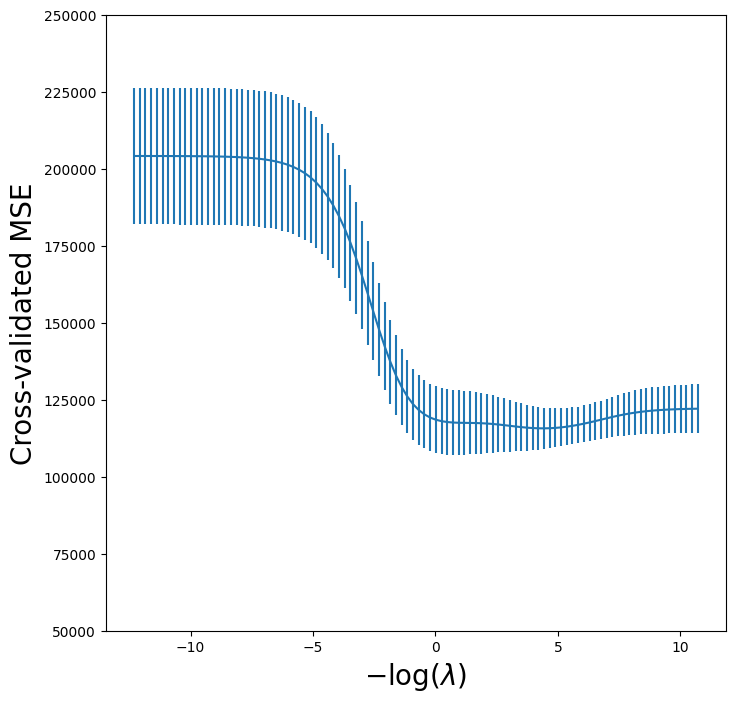

In [105]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))

ax.set_ylim([50000, 250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

In [ ]:
# One can cross-validate different metrics to choose a parameter. The default metric for skl.ElasticNet() is test R**2.Lets compare R**2 to MSE for cross-validation here.

grid_r2 = skm.GridSearchCV(pipe,
                           param_grid,
                           cv=kfold)
grid_r2.fit(X,Y)

Text(0, 0.5, 'Cross -validated $R^2$')

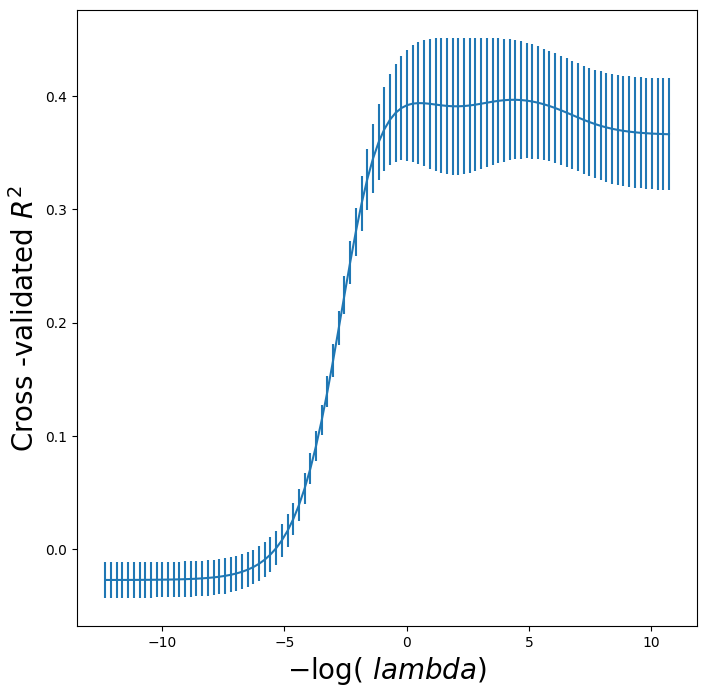

In [109]:
r2_fig , ax = subplots(figsize =(8 ,8))
ax.errorbar(-np.log(lambdas),
    grid_r2.cv_results_['mean_test_score'],
    yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K)
    )
ax.set_xlabel('$-\log(\ lambda)$', fontsize =20)
ax.set_ylabel('Cross -validated $R^2$', fontsize =20)

PCR and PLS Regression

In [110]:
# We will use PCA to decompose the Hitters data and then use LinearRegression() to fit the regression model here.

pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('pca',pca), ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([0.09846131, 0.4758765 ])

In [111]:
# When performing PCA, the results vary depending on whether the data has been standardized or not. As in the earlier examples, this can be accomplished by including an additional step in the pipeline

pipe = Pipeline([('scaler', scaler),
                 ('pca', pca),
                 ('linreg',linreg)])
pipe.fit(X,Y)
pipe.named_steps['linreg'].coef_


array([106.36859204, -21.60350456])

In [112]:
# We can of course use CV to choose the number of components, by using skm.GridSearchCV, in this case fixing the parameters to vary the n_components.

param_grid = {'pca__n_components': range(1,20)}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

(50000.0, 250000.0)

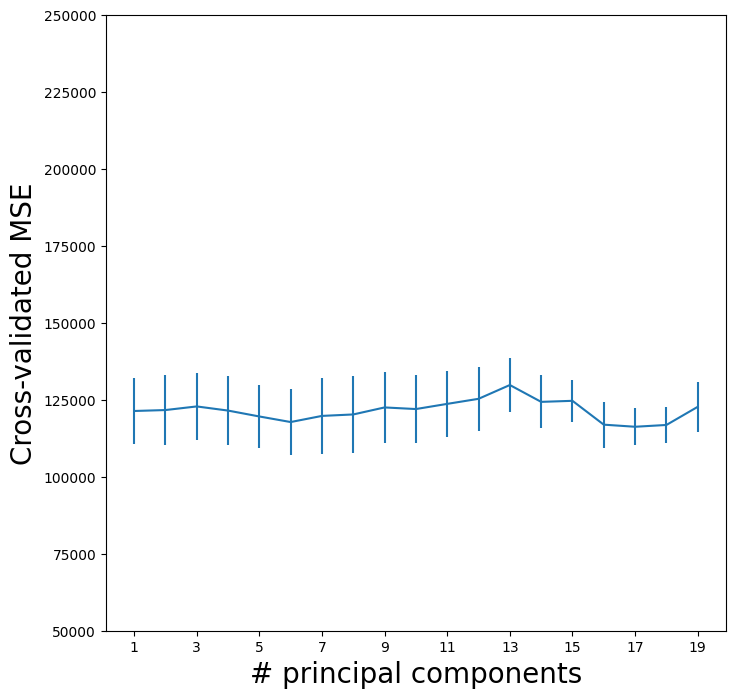

In [113]:
pcr_fig, ax = subplots(figsize=(8,8))

n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))

ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000])


In [114]:
Xn = np.zeros((X.shape[0], 1))
cv_null = skm.cross_validate(linreg, Xn, Y, cv=kfold, scoring='neg_mean_squared_error')
-cv_null['test_score'].mean()

204139.30692994667

In [115]:
# The explained_variance_ratio_ atrribute of our PCA object provides the percentage of variance explained in the predictors and in the reponse using different numbers of components. This concept is discussed in greater detail 

pipe.named_steps['pca'].explained_variance_ratio_

array([0.3831424 , 0.21841076])

In [116]:
pls = PLSRegression(n_components=2, scale=True)
pls.fit(X,Y)

PLSRegression()

In [117]:
param_grid = {'n_components':range(1,20)}
grid=skm.GridSearchCV(pls,
                      param_grid,
                      cv=kfold,
                      scoring='neg_mean_squared_error')

In [118]:
grid.fit(X,Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

(50000.0, 250000.0)

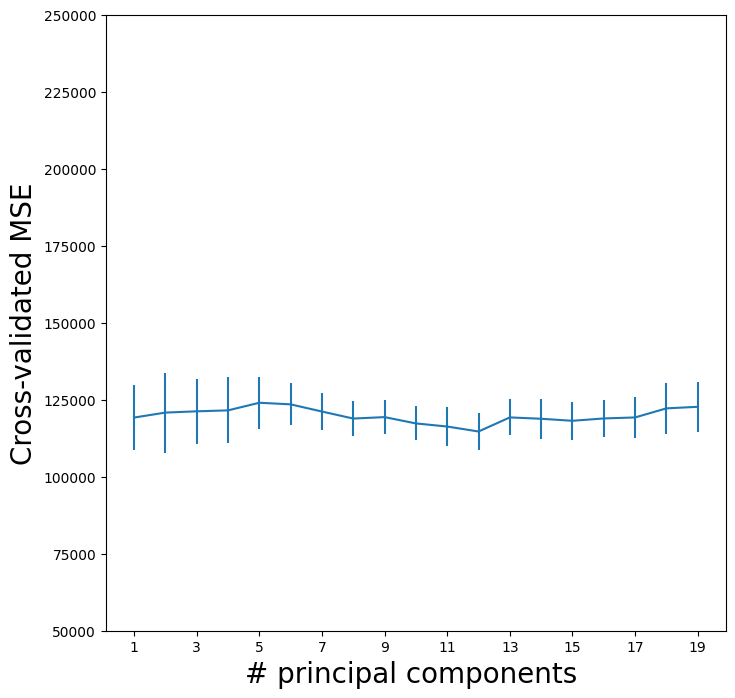

In [120]:
pls_fig , ax = subplots(figsize =(8 ,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp ,
    -grid.cv_results_['mean_test_score'],
    grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize =20)
ax.set_xlabel('# principal components ', fontsize =20)
ax.set_xticks(n_comp [::2])
ax.set_ylim ([50000 ,250000])